In [5]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import os
import warnings
from dask import dataframe as df

In [6]:
#!pip install textblob
#!pip install WordCloud
#!pip install spacy

In [7]:
from dask.distributed import Client
from dask import dataframe as dd
import dask.bag as db
#client = Client(n_workers=8)
#client

In [4]:
#clientnt.restart()

In [8]:
%%time
imbd_data=dd.read_csv("IMDB Dataset.csv").compute()
imbd_data.head()

CPU times: user 334 ms, sys: 85 ms, total: 419 ms
Wall time: 418 ms


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000


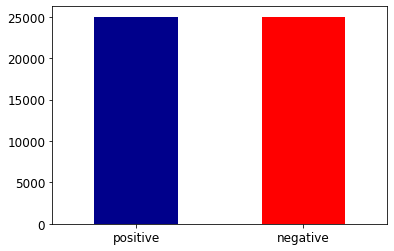

In [9]:
print(imbd_data.describe())
#Text Preprocessing
imbd_data['sentiment'].value_counts().plot.bar(color=['darkblue', 'r'], rot=0, fontsize='large')
plt.show()

In [7]:
#imbd_data['sentiment'].value_counts()

In [10]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [11]:
#Čiščenje besedila
def cleaning(x):
    x = re.sub('[,\.!?:()"]', '', x)
    x = re.sub('<.*?>', ' ', x)
    x = re.sub('http\S+', ' ', x)
    x = re.sub('[^a-zA-Z0-9]', ' ', x)
    x = re.sub('\s+', ' ', x)
    return x.lower().strip()

#Odstranjevanj stopwords

sw_set = set(nltk.corpus.stopwords.words('english'))
#@delayed
def sw_remove(x):
    words = nltk.tokenize.word_tokenize(x)
    filtered_list = [word for word in words if word not in sw_set]
    return ' '.join(filtered_list)


In [12]:
%%time
imbd_data['review']=imbd_data['review'].apply(lambda x: cleaning(x))
imbd_data['review'] =imbd_data['review'].apply(lambda x: sw_remove (x))

CPU times: user 28.4 s, sys: 23.3 ms, total: 28.4 s
Wall time: 28.5 s


In [11]:
"""%%time
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
imbd_data['review']=imbd_data['review'].apply(denoise_text)"""

'%%time\n#Removing the html strips\ndef strip_html(text):\n    soup = BeautifulSoup(text, "html.parser")\n    return soup.get_text()#Removing the square brackets\ndef remove_between_square_brackets(text):\n    return re.sub(\'\\[[^]]*\\]\', \'\', text)#Removing the noisy text\ndef denoise_text(text):\n    text = strip_html(text)\n    text = remove_between_square_brackets(text)\n    return text\n#Apply function on review column\nimbd_data[\'review\']=imbd_data[\'review\'].apply(denoise_text)'

In [12]:
"""%%time
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imbd_data['review']=imbd_data['review'].apply(remove_special_characters)"""

"%%time\n#Define function for removing special characters\ndef remove_special_characters(text, remove_digits=True):\n    pattern=r'[^a-zA-z0-9\\s]'\n    text=re.sub(pattern,'',text)\n    return text\n#Apply function on review column\nimbd_data['review']=imbd_data['review'].apply(remove_special_characters)"

In [13]:
"""%%time
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column

imbd_data['review']=imbd_data['review'].apply(simple_stemmer)"""

"%%time\n#Stemming the text\ndef simple_stemmer(text):\n    ps=nltk.porter.PorterStemmer()\n    text= ' '.join([ps.stem(word) for word in text.split()])\n    return text\n#Apply function on review column\n\nimbd_data['review']=imbd_data['review'].apply(simple_stemmer)"

In [14]:
"""%%time
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
imbd_data['review']=imbd_data['review'].apply(remove_stopwords)"""

"%%time\n#set stopwords to english\nstop=set(stopwords.words('english'))\nprint(stop)\n\n#removing the stopwords\ndef remove_stopwords(text, is_lower_case=False):\n    tokens = tokenizer.tokenize(text)\n    tokens = [token.strip() for token in tokens]\n    if is_lower_case:\n        filtered_tokens = [token for token in tokens if token not in stopword_list]\n    else:\n        \n        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]\n    filtered_text = ' '.join(filtered_tokens)    \n    return filtered_text\n#Apply function on review column\nimbd_data['review']=imbd_data['review'].apply(remove_stopwords)"

In [13]:
%%time
norm_train_reviews=imbd_data['review'][:40000]
norm_test_reviews=imbd_data['review'][20000:]
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (40000, 6426748)
BOW_cv_test: (30000, 6426748)
CPU times: user 36.4 s, sys: 931 ms, total: 37.3 s
Wall time: 37.4 s


In [16]:
"""%%time
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)"""

"%%time\n#Tfidf vectorizer\ntv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))\n#transformed train reviews\ntv_train_reviews=tv.fit_transform(norm_train_reviews)\n#transformed test reviews\ntv_test_reviews=tv.transform(norm_test_reviews)\nprint('Tfidf_train:',tv_train_reviews.shape)\nprint('Tfidf_test:',tv_test_reviews.shape)"

In [14]:
%%time
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(imbd_data['sentiment'])
print(sentiment_data)
#Spliting the sentiment data
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[20000:]
print(len(train_sentiments))
print(len(test_sentiments))


[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]
40000
30000
CPU times: user 95.4 ms, sys: 181 µs, total: 95.6 ms
Wall time: 94.4 ms


In [15]:
%%time
#print(tv_train_reviews.shape[0])
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
#print(cv_test_reviews.shape[0]," ",len(train_sentiments))
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)

#fitting the svm for tfidf features
"""""
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)
print('Tfidf_test:',tv_test_reviews.shape)"""""

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()
CPU times: user 289 ms, sys: 72 ms, total: 361 ms
Wall time: 359 ms


'""\nmnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)\nprint(mnb_tfidf)\nprint(\'Tfidf_test:\',tv_test_reviews.shape)'

In [16]:
%%time
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
#mnb_tfidf_predict=mnb.predict(tv_test_reviews)
#print(mnb_tfidf_predict)

[0 0 1 ... 0 1 1]
CPU times: user 94.8 ms, sys: 12.1 ms, total: 107 ms
Wall time: 104 ms


In [17]:
%%time
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#"""#Accuracy score for tfidf features
#mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
#print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.9129333333333334
CPU times: user 3.62 ms, sys: 0 ns, total: 3.62 ms
Wall time: 2.85 ms


In [18]:
%%time
#Classification report for bag of words 
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)

#Classification report for tfidf features
"""mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)"""

              precision    recall  f1-score   support

    Positive       0.90      0.92      0.91     14903
    Negative       0.92      0.90      0.91     15097

    accuracy                           0.91     30000
   macro avg       0.91      0.91      0.91     30000
weighted avg       0.91      0.91      0.91     30000

CPU times: user 36.2 ms, sys: 3.91 ms, total: 40.1 ms
Wall time: 39.5 ms


"mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])\nprint(mnb_tfidf_report)"

In [19]:
%%time
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)


"""#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)"""

[[13648  1449]
 [ 1163 13740]]
CPU times: user 15.9 ms, sys: 58 µs, total: 15.9 ms
Wall time: 14.5 ms


'#confusion matrix for tfidf features\ncm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])\nprint(cm_tfidf)'

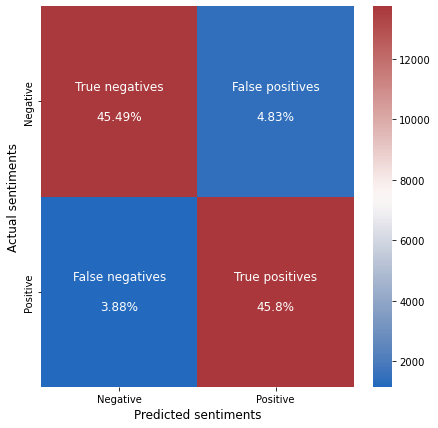

In [20]:
cf_matrix=cm_bow
legends = ['True negatives', 'False positives', 'False negatives', 'True positives']
percentages = [round(100*num, 2) for num in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n\n{v2}%' for v1, v2 in zip(legends, percentages)]
labels = np.asarray(labels).reshape(2, 2)

# Heatmap 
plt.figure(figsize = (7, 7))

cm = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='vlag', annot_kws={'fontsize': 'large'})
cm.set_xlabel('Predicted sentiments', size='large')
cm.set_ylabel('Actual sentiments', size='large')
cm.xaxis.set_ticklabels(['Negative', 'Positive'])
cm.yaxis.set_ticklabels(['Negative', 'Positive'])

plt.show()

CPU times: user 330 ms, sys: 8.04 ms, total: 338 ms
Wall time: 336 ms


<function matplotlib.pyplot.show(close=None, block=None)>

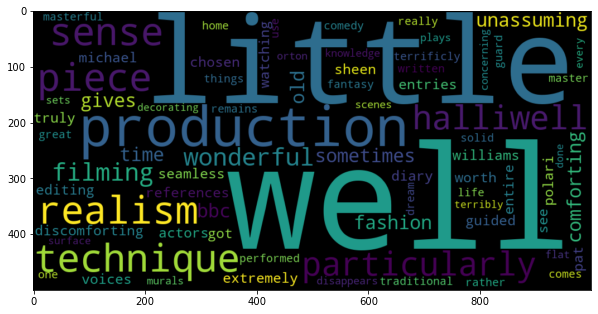

In [21]:
%%time
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

CPU times: user 284 ms, sys: 3.89 ms, total: 288 ms
Wall time: 287 ms


<function matplotlib.pyplot.show(close=None, block=None)>

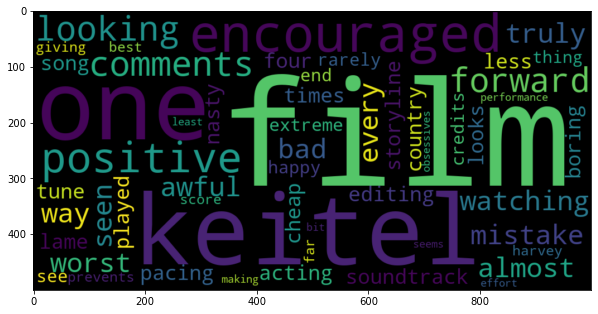

In [22]:
%%time
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

In [24]:
import random

df_original = pd.read_csv('IMDB Dataset.csv')
test_rev=imbd_data['review']
# Izbiranje naključnega reviewa

idx_test = random.randint(0, len(test_sentiments)-1)
idx_original = test_rev.index[idx_test]
(actual_rev, actual_sent) = df_original.iloc[idx_original]

# Primerjanje original ocene z "naučeno" oceno naključno izbranega 
prediction = mnb_bow_predict[idx_test]
prediction=prediction*mnb_bow_score if prediction<0.5 else prediction*mnb_bow_score

prediction_sent = 'positive' if prediction >= 0.5 else 'negative'
prediction=mnb_bow_score
probability = round(prediction if prediction >= 0.5 else 1-prediction, 2)

# Izpis

print('\033[1m' + 'Review #%d:' % idx_original + '\033[0m' + '\n', actual_rev, '\n')
print('\033[1m' + 'Napovedana ocena:' + '\033[0m', prediction_sent, '(z verjetnostjo %.2f)' % probability, '\n')
print('\033[1m' + 'Dejanska ocena:' + '\033[0m', actual_sent)

Review #13681:
 Witchcraft/Witchery/La Casa 4/ and whatever else you wish to call it. How about..Crud.<br /><br />A gathering of people at a Massachusetts island resort are besieged by the black magic powers of an evil witch killing each individual using cruel, torturous methods. Photographer Gary(David Hasselhoff)is taking pictures for Linda(Catherine Hickland whose voice and demeanor resemble EE-YOR of the Winnie the Poo cartoon), a virgin studying witchcraft, on the island resort without permission. Rose Brooks(Annie Ross, portraying an incredibly rude bitch)is interested in perhaps purchasing the resort and, along with husband Freddie(Robert Champagne, who is always ogling other women much younger than him), pregnant daughter Jane(Linda Blair)and grandson Tommy(Michael Manchester, who just looks bored throughout, probably wanting to watch Sesame Street instead of starring in this rubbish), go by boat to the resort being treated to a look at the property by Realtor Tony Giordano's s